# Model Explanation Binary

## Dataset & Model Loading

In [2]:
import pandas as pd
import numpy as np
import joblib
import shap
import matplotlib.pyplot as plt
import os
import sys
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '..')))
from utils.text_preprocessing import preprocess_text
shap.initjs()

df_train = pd.read_csv("../dataset/training_set.csv")  
df_train = df_train[['text', 'binary_label']]
df_train = df_train[
    df_train['text'].notna() & df_train['text'].str.strip().astype(bool)
]

X_text = df_train["text"].fillna("").astype(str)
y_binary = df_train["binary_label"].map({
    "cyberbullying": 1,
    "not_cyberbullying": 0
})
       
pipeline_binary = joblib.load("../model/binary/LogisticRegression_TF-IDF.pkl")

lr_binary = pipeline_binary.named_steps["model"]          

tfidf_vectorizer_binary = pipeline_binary.named_steps["vectorizer"]

vocab = tfidf_vectorizer_binary.get_feature_names_out()

print("\nBinary pipeline steps:")
print(pipeline_binary.steps)
print("\nExtracted model types:")
print("Binary model:   ", type(lr_binary))
print("Binary vocab size:   ", len(tfidf_vectorizer_binary.get_feature_names_out()))



Binary pipeline steps:
[('preprocessing', TextPreprocessor()), ('vectorizer', TfidfVectorizer(min_df=0.005)), ('smote', SMOTE(random_state=42)), ('model', LogisticRegression(C=1, class_weight='balanced', max_iter=1000))]

Extracted model types:
Binary model:    <class 'sklearn.linear_model._logistic.LogisticRegression'>
Binary vocab size:    392


## Local Binary Model Explanation

0    fuck bad idea say terribl lie alli see
Name: text, dtype: object
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
0    realli hope bulli gay school
Name: original_text, dtype: object
[[0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.27000567]
 [0.         0.         0.         ... 0.         0.         0.        ]]
feature correcly labeled

=== SHAP Explanation ===
SHAP prediction (sum): 0.8185
Model predicted proba (class 1): 0.8185
True class:(age)
Text preview: Really hope they bully the gay out of him at school....



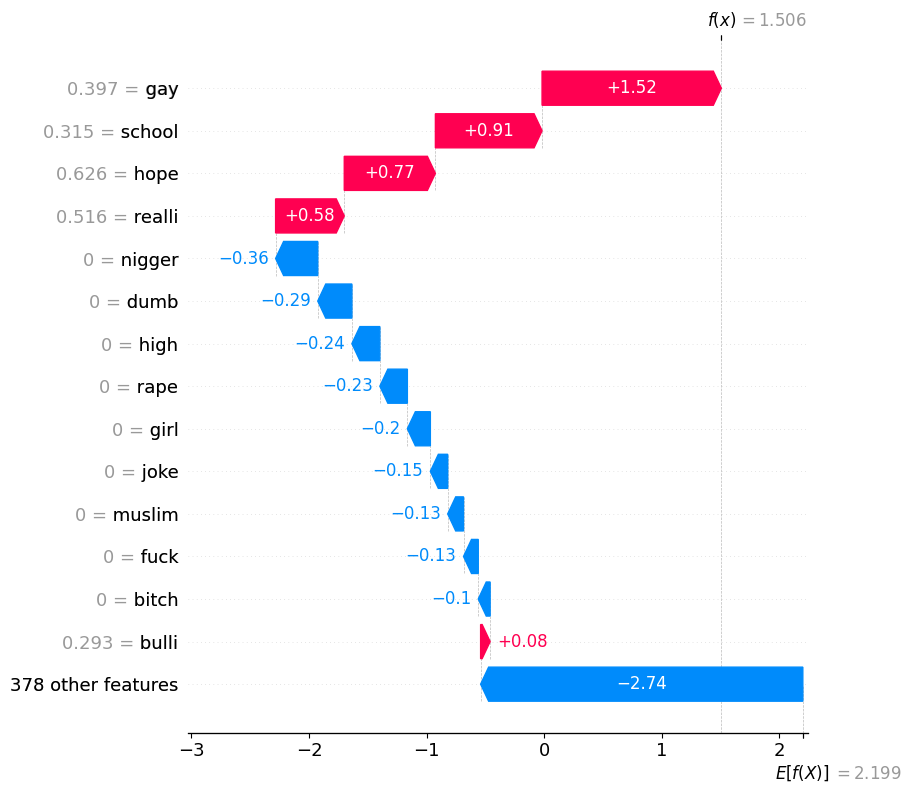


=== SHAP Explanation ===
SHAP prediction (sum): 0.9997
Model predicted proba (class 1): 0.9997
True class:(ethnicity)
Text preview: dumb niggers fuck all of u...



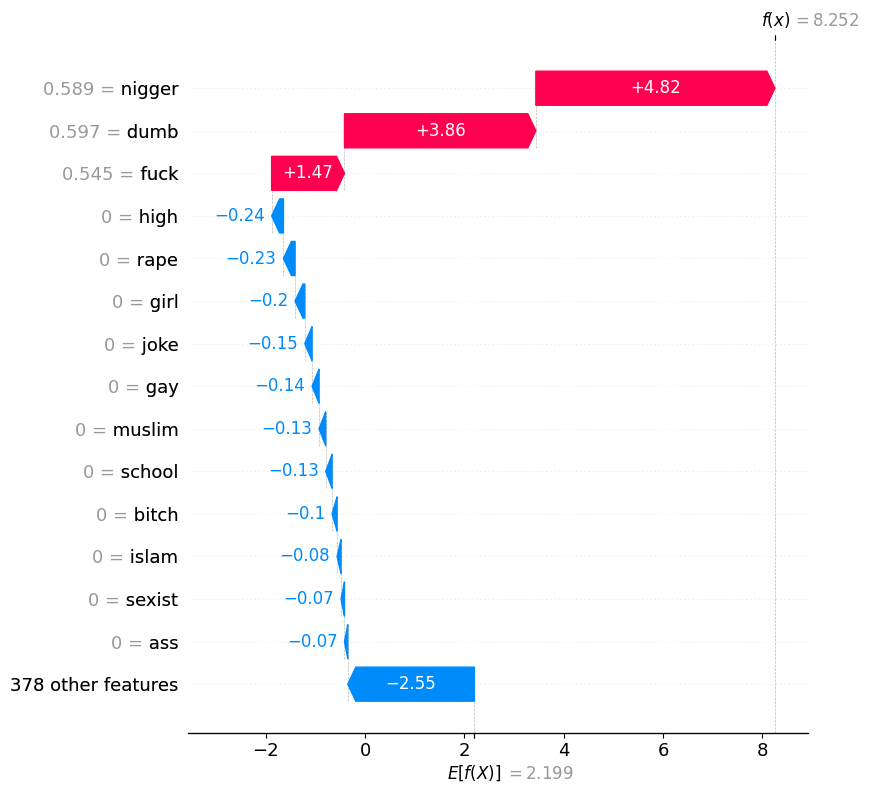


=== SHAP Explanation ===
SHAP prediction (sum): 0.9613
Model predicted proba (class 1): 0.9613
True class:(gender)
Text preview: RT @ConnellyBock Im not sexist but I hate woman sports commentators...



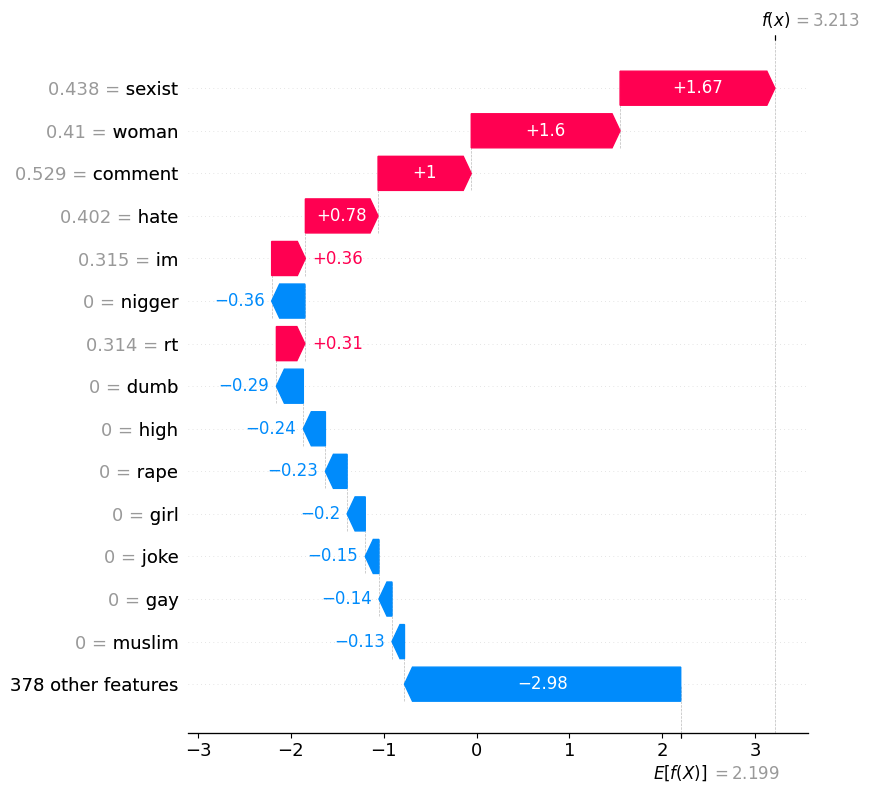


=== SHAP Explanation ===
SHAP prediction (sum): 0.8582
Model predicted proba (class 1): 0.8582
True class:(other_cyberbullying)
Text preview: @Only1_SHARA Ugly ass had me thinking God was doing a roll call ð©ð...



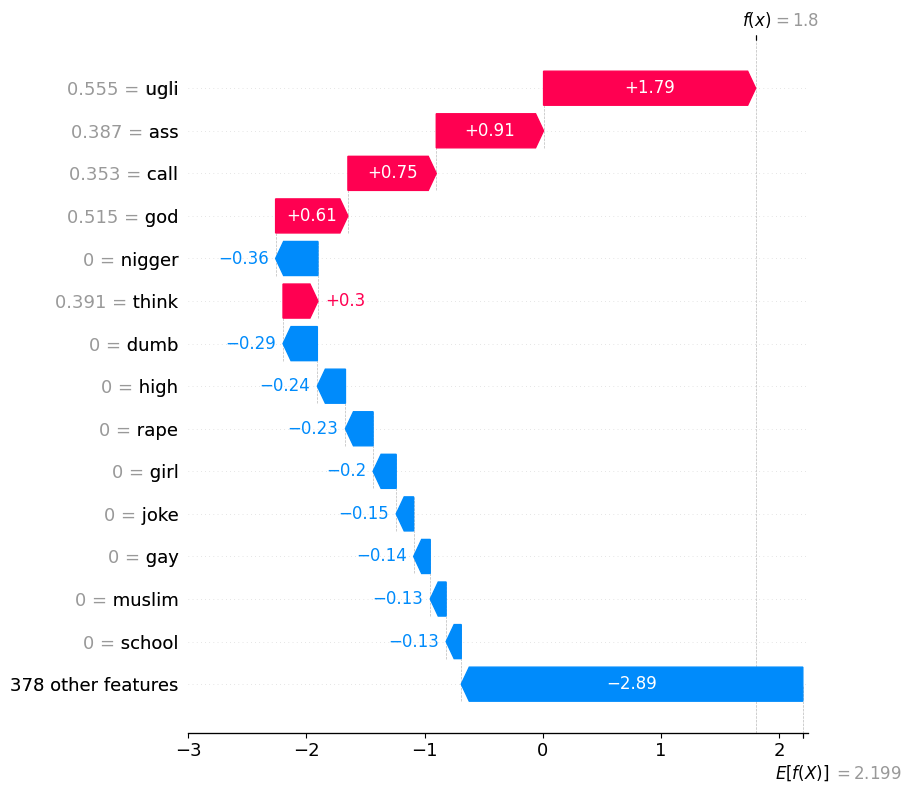


=== SHAP Explanation ===
SHAP prediction (sum): 0.9874
Model predicted proba (class 1): 0.9874
True class:(religion)
Text preview: You should visit a Muslim country and see how WOKE they are, right before you're beheaded like the 2 British girl idiots who thought vacationing in Mo...



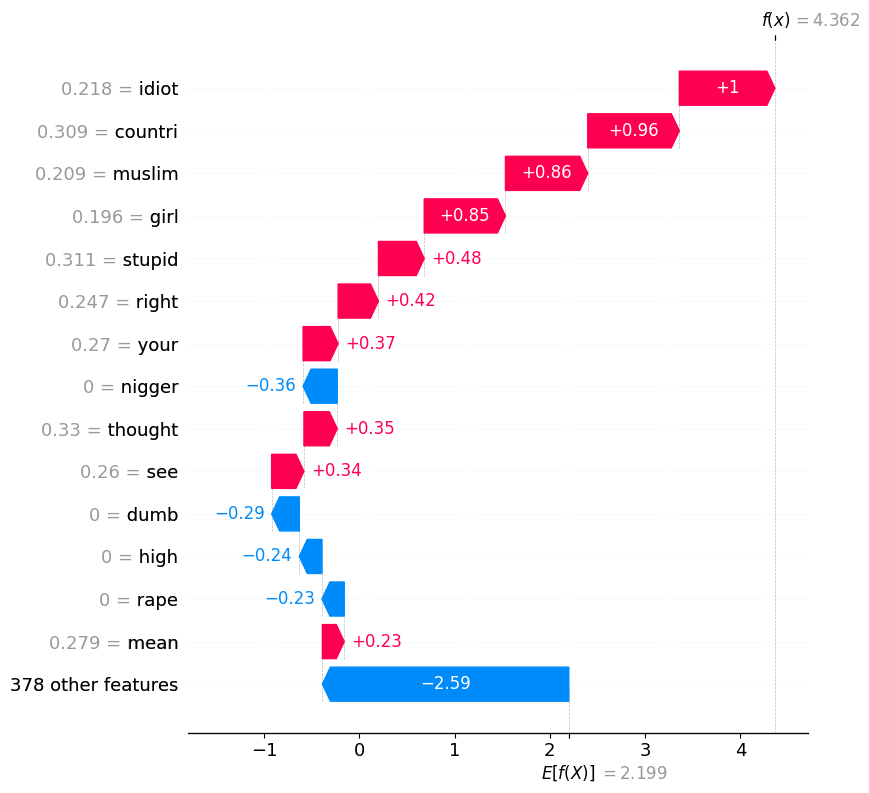


=== SHAP Explanation ===
SHAP prediction (sum): 0.3575
Model predicted proba (class 1): 0.3575
True class:(not_cyberbullying)
Text preview: The fact that i just paid $7 for a fruit cup and a coffee at school is insane...



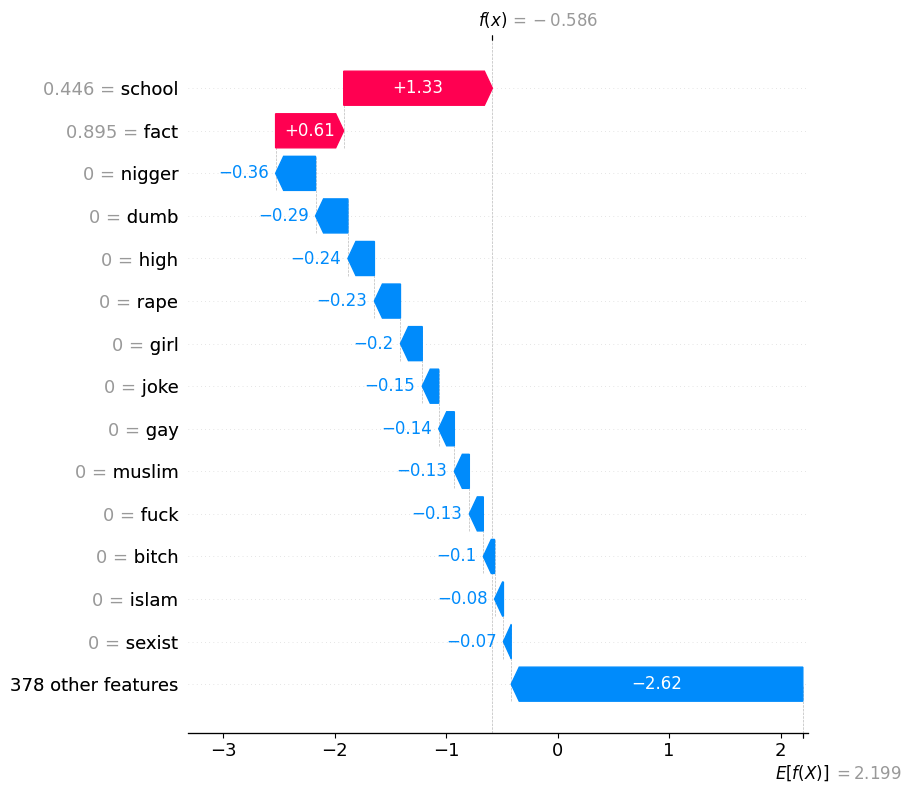

In [3]:


X_train = X_text.apply(preprocess_text)
print(X_train.head(1))
X_train= tfidf_vectorizer_binary.transform(X_train).toarray().astype("float32")
print(X_train)

test = pd.read_csv("../dataset/selected_explanable_example.csv")
X_test = test["original_text"].apply(preprocess_text)
print(X_test.head(1))
X_test= tfidf_vectorizer_binary.transform(X_test).toarray().astype("float32")
print(X_test)

explainer = shap.Explainer(lr_binary, X_train) 
shap_values = explainer(X_test)

if len(vocab) == shap_values.shape[1]:   
    shap_values.feature_names = list(vocab)
    print("feature correcly labeled")
else:
    raise Exception("something goes wrong")
for i in range(len(test)):
    label_id = test.loc[i, "label_id"]
    label_name = test.loc[i, "label_name"]
    text = test.loc[i, "original_text"]
    proba = lr_binary.predict_proba(X_test[i].reshape(1, -1))[0, 1]
    logit_shap = explainer.expected_value + shap_values[i].values.sum()
    proba_shap = 1 / (1 + np.exp(-logit_shap))

    print(f"\n=== SHAP Explanation ===")
    print(f"SHAP prediction (sum): {proba_shap:.4f}")
    print(f"Model predicted proba (class 1): {proba:.4f}")
    print(f"True class:({label_name})")
    print(f"Text preview: {text[:150]}...\n")
    shap.plots.waterfall(shap_values[i], max_display=15, show=False)
    plt.savefig(f"../SHAP/waterfall_plot_{label_name}.png", bbox_inches="tight", dpi=300)
    plt.close()
    shap.plots.waterfall(shap_values[i], max_display=15)


## Global Binary Model Explanation



Top 100 Feature Count:
 - cyberbullying      : 98
 - not_cyberbullying  : 2

Top 100 Feature Count:
 - cyberbullying      : 385
 - not_cyberbullying  : 7


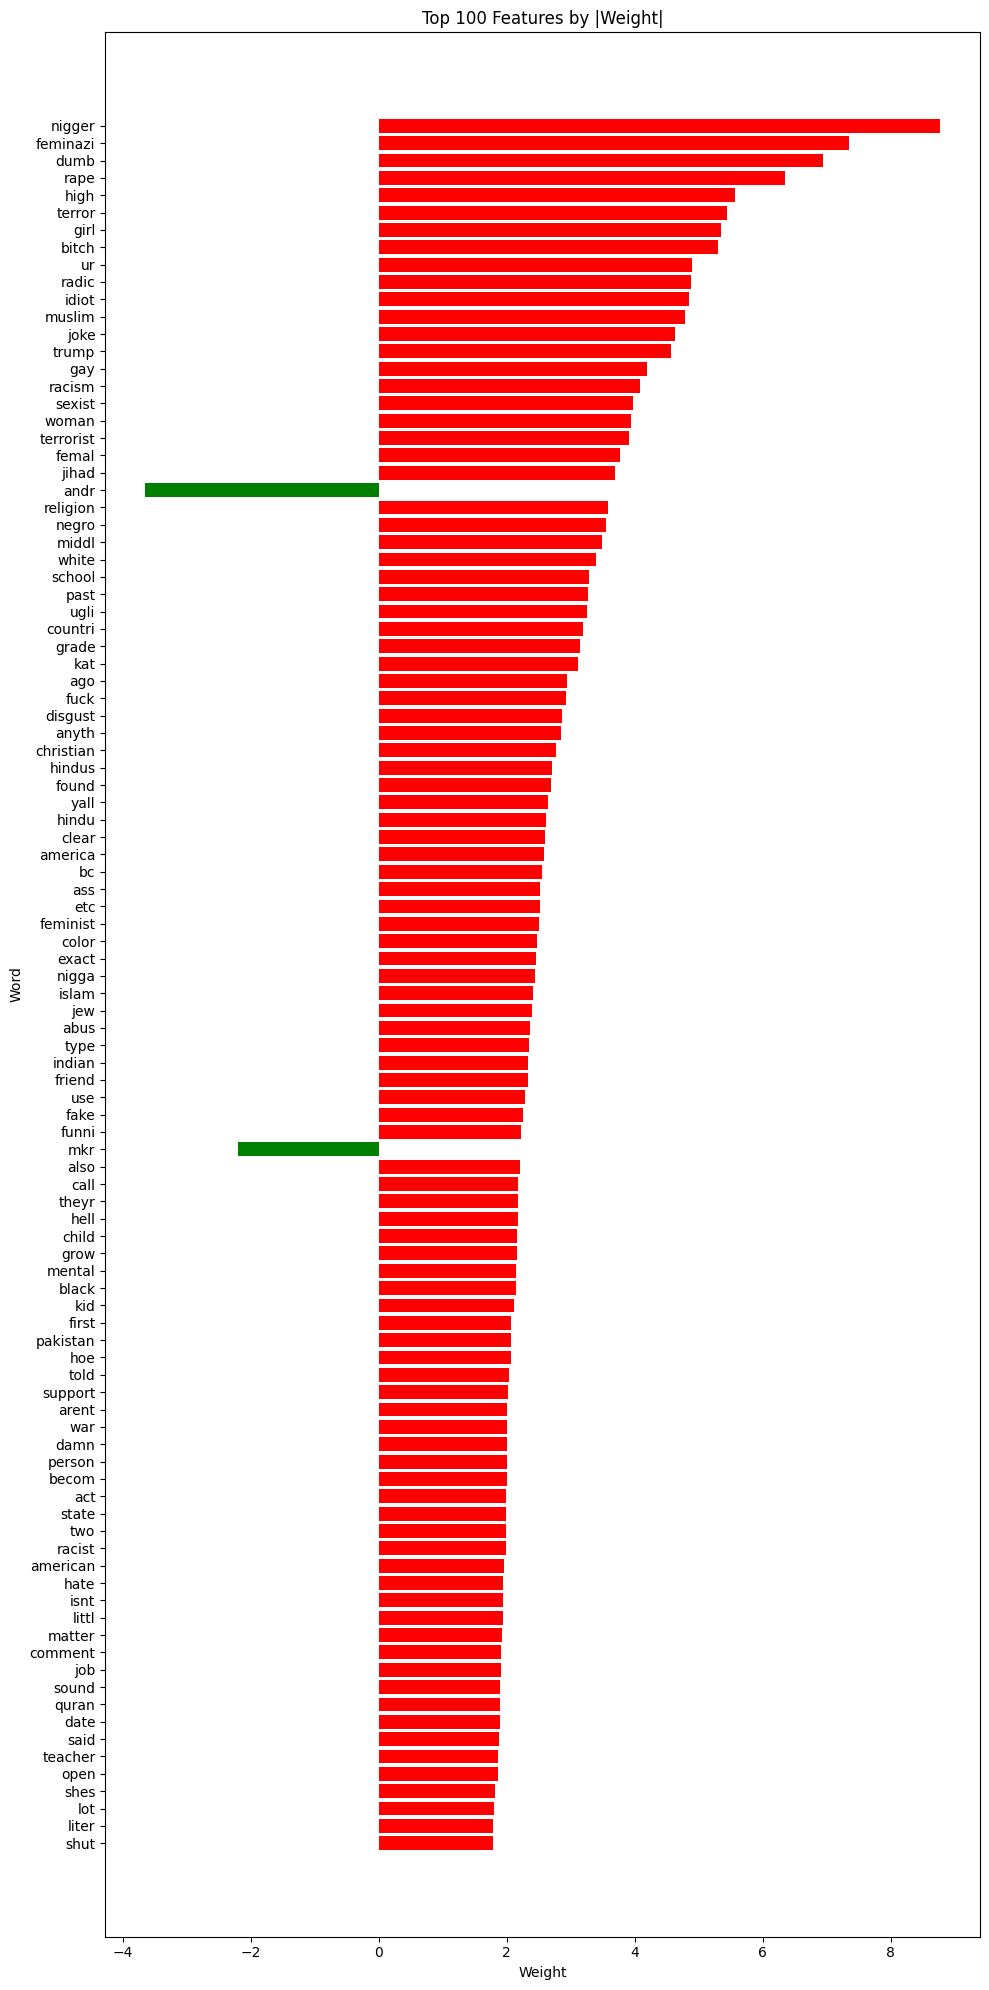

In [ ]:
coeffs = lr_binary.coef_[0] 
vocab = tfidf_vectorizer_binary.get_feature_names_out()
important_words = sorted(zip(vocab, coeffs), key=lambda x: abs(x[1]), reverse=True)

top_n = 100
top_features = important_words[:top_n]

count_cyber = sum(1 for _, w in top_features if w > 0)
count_not = sum(1 for _, w in top_features if w < 0)

print(f"\nTop {top_n} Feature Count:")
print(f" - cyberbullying      : {count_cyber}")
print(f" - not_cyberbullying  : {count_not}")

top_features = important_words[:]

count_cyber = sum(1 for _, w in top_features if w > 0)
count_not = sum(1 for _, w in top_features if w < 0)

print(f"\nAll Feature Count:")
print(f" - cyberbullying      : {count_cyber}")
print(f" - not_cyberbullying  : {count_not}")

top_n = 100
top_features = important_words[:top_n]

count_cyber = sum(1 for _, w in top_features if w > 0)
count_not = sum(1 for _, w in top_features if w < 0)

df = pd.DataFrame(top_features, columns=["Word", "Weight"])
df["Direction"] = df["Weight"].apply(lambda x: "cyberbullying" if x > 0 else "not_cyberbullying")

count_cyber, count_not, df.head()

df_sorted = df.reindex(df["Weight"].abs().sort_values(ascending=False).index)

plt.figure(figsize=(10, 20))
plt.barh(df_sorted["Word"], df_sorted["Weight"], color=df_sorted["Direction"].map({
    "cyberbullying": "red", "not_cyberbullying": "green"
}))
plt.xlabel("Weight")
plt.ylabel("Word")
plt.title(f"Top {top_n} Features by |Weight|")
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()